# Text2vec-base-multilingual

https://huggingface.co/shibing624/text2vec-base-multilingual

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain


import matplotlib.pyplot as plt
import pandas as pd

threshold = [4,5, 6, 8, 9, 10]
file_list_1 = ["data_3005(puntoevirgola).csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
file_list_2 = ["data_0905_semicolon.csv","data_2705_semicolon.csv","data_3005(puntoevirgola).csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
target = [-1, 0, 1]
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


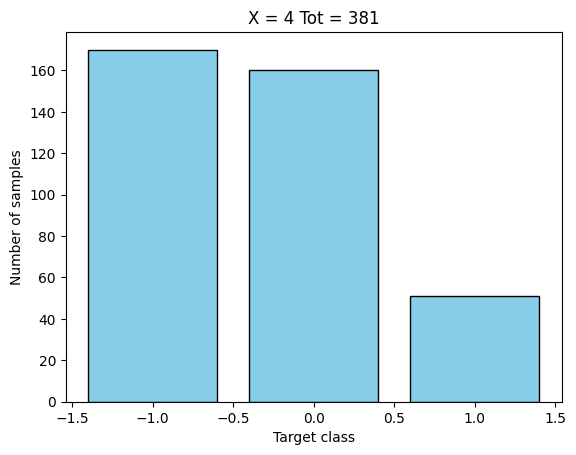

[170, 160, 51]


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
135,HAL,"Top news on May 28: HAL stock in focus, Rafale...","Should you buy Bharti Airtel, Hindustan Aerona...",Halliburton (NYSE:HAL) Shares Sold by D.A. Dav...,"HAL stock in focus as India, France to begin t...",,,,,,,1.0,"Top news on May 28: HAL stock in focus, Rafale..."
175,NVDA,Why You Don’t Need Need to Buy Nvidia Stock Ri...,"1 Favorable Trend Explains the 1,600% Rise in ...",Stock Market Today: Dow Jones Falls As Nvidia ...,Is NVIDIA Corporation (NASDAQ:NVDA) The Top Qu...,,,,,,,1.0,Why You Don’t Need Need to Buy Nvidia Stock Ri...
309,JNJ,Johnson &amp; Johnson (NYSE:JNJ) Stock's Been ...,Johnson &amp; Johnson (NYSE:JNJ) Trading Down ...,Johnson &amp; Johnson (JNJ) Bernstein's 40th A...,Johnson &amp; Johnson (JNJ) is Attracting Inve...,,,,,,,0.0,Johnson &amp; Johnson (NYSE:JNJ) Stock's Been ...


In [2]:
all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold
T = 4
for file_name in file_list_1:                                                                           #METTERE FILE LIST 1
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set

'''
# We rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])
'''

plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = '+ str(T)+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
input_df = input_df.dropna(axis=0)
input_df.sample(n=3)

In [3]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

y_train = y_train + 1            
y_test = y_test + 1
y_val = y_val + 1

### Here starts the model training

In [4]:
from sentence_transformers import SentenceTransformer

model_name = 'shibing624/text2vec-base-multilingual'
m = SentenceTransformer(model_name)  

In [5]:
c = len(m.encode("I love embeddings!"))                   # dim embedding
r = x_train.shape[0]    # dim dataset  

x_train_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_train.iloc[idx,:].loc["Concatenated Titles"])
  x_train_emb[idx,:] = sentence_embeddings



r = x_val.shape[0]    # dim dataset  
x_val_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_val.iloc[idx,:].loc["Concatenated Titles"])
  x_val_emb[idx,:] = sentence_embeddings


r = x_test.shape[0]    # dim dataset  
x_test_emb = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(x_test.iloc[idx,:].loc["Concatenated Titles"])
  x_test_emb[idx,:] = sentence_embeddings

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [7]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train.Target.iloc[i])  
    y_train_dummy[i, class_idx] = 1


y_val_dummy = np.zeros((len(y_val), num_classes))
for i in range(0,len(y_val)):
  y_val_dummy[i,round(y_val.Target.iloc[i])] = 1

y_test_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
  y_test_dummy[i,round(y_test.Target.iloc[i])] = 1

In [8]:
def create_m1(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=100, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',                                    # tf.keras.losses.CategoricalCrossentropy should be more appropriate but I cannot make it work
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0) 
    return model
def create_m2(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=30, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)  
    return model

def create_m3(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=300, activation='relu', input_dim=c))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0)  
    return model
def create_m4(epo,lr,bat,x,y):
    model=Sequential()
    model.add(Dense(units=900, activation='relu', input_dim=c))
    model.add(Dense(units=50, activation='tanh'))
    model.add(Dense(units=3, activation='sigmoid'))    #output layer
    model.compile(loss='mse',
                  optimizer=Adam(lr=lr,beta_1=0.9,beta_2=0.999))
    model.fit(x,y,epochs=epo,batch_size=bat,verbose=0) 
    return model

def get_validation_missclas(y_pred, target):
    return np.sum(y_pred != target) / len(target)


In [9]:
fun_lst = [create_m1,create_m2,create_m3,create_m4]
epo_list = [3, 5,10,20,100]
lr = 0.001                              # values between 0.001 and 0.0001 should be fine 
batch_size_list = [5,8,10,20] 
best_performance = 10
# 80 models will be trained
for function in fun_lst:
    for epo in epo_list:
        for bat in batch_size_list:
            model = function(epo,lr,bat,x_train_emb,y_train_dummy)
            pred_val_raw=model.predict(x_val_emb)
            pred_val = np.argmax(pred_val_raw, axis=1)
            miss = get_validation_missclas(pred_val, np.argmax(y_val_dummy, axis=1))
            if miss < best_performance:
                best_performance = miss
                opt_model, opt_fun, opt_epo, opt_bat = model, function, epo, bat

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 0s 2ms/step


In [10]:
print(best_performance, opt_model, opt_fun, opt_epo, opt_bat,sep="\n")
predictions = opt_model.predict(x_test_emb)

0.4426229508196721
<function create_m1 at 0x00000196A21DB798>
3
5
3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 1ms/step
Precision (train): 0.53877809433365
Recall (train): 0.6172839506172839
F1-score (train): 0.5732590978778344
Precision (val): 0.5147328999434708
Recall (val): 0.5573770491803278
F1-score (val): 0.5332707361240192
Precision (test): 0.32482460068666963
Recall (test): 0.4155844155844156
F1-score (test): 0.36064274708342503
Misclassification_train: 0.38271604938271603
Misclassification_val: 0.4426229508196721
Misclassification_test: 0.5844155844155844


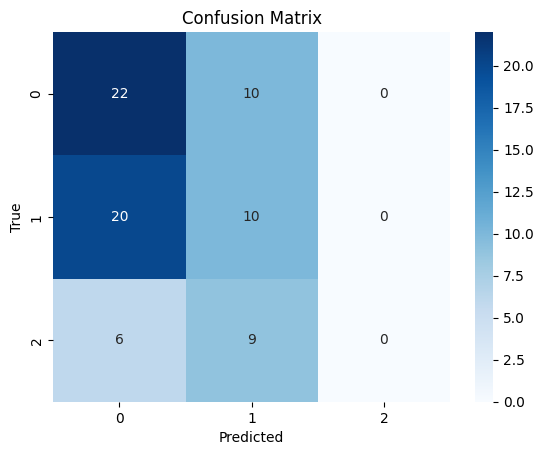

In [12]:
model  = opt_model
# Install whichever package or library is missing for you
#!pip install sentence-transformers
#!pip install numpy pandas scikit-learn seaborn matplotlib keras
#import pandas as pd
#import numpy as np
#import tensorflow as tf
import seaborn as sns
#import matplotlib.pyplot as plt
#import random as rand
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam, RMSprop, SGD, Adagrad
#from sentence_transformers import SentenceTransformer
#from transformers import TFBertForSequenceClassification, BertTokenizer, BertConfig
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Making predictions
pred_train = model.predict(x_train_emb)
pred_val = model.predict(x_val_emb)
pred_test = model.predict(x_test_emb)

# Converting predictions to binary arrays
def to_binary(pred):
    pred_binary = np.zeros(pred.shape)
    for i in range(len(pred)):
        pred_binary[i, pred[i, :].argmax()] = 1
    return pred_binary

pred_train_2 = to_binary(pred_train)
pred_val_2 = to_binary(pred_val)
pred_test_2 = to_binary(pred_test)

# Converting predictions to class labels
y_train_pred_labels = np.argmax(pred_train, axis=1)
y_val_pred_labels = np.argmax(pred_val, axis=1)
y_test_pred_labels = np.argmax(pred_test, axis=1)

# Converting one-hot encoded true labels to class labels
y_train_true_labels = np.argmax(y_train_dummy, axis=1)
y_val_true_labels = np.argmax(y_val_dummy, axis=1)
y_test_true_labels = np.argmax(y_test_dummy, axis=1)

# Evaluating the model (precision, recall, F1-score, MSE, misclassification and confusion matrix)

# Presicison, recall and F1-Score
def evaluate_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

precision_train, recall_train, f1_train = evaluate_performance(y_train_true_labels, y_train_pred_labels)
precision_val, recall_val, f1_val = evaluate_performance(y_val_true_labels, y_val_pred_labels)
precision_test, recall_test, f1_test = evaluate_performance(y_test_true_labels, y_test_pred_labels)

print("Precision (train):", precision_train)
print("Recall (train):", recall_train)
print("F1-score (train):", f1_train)

print("Precision (val):", precision_val)
print("Recall (val):", recall_val)
print("F1-score (val):", f1_val)

print("Precision (test):", precision_test)
print("Recall (test):", recall_test)
print("F1-score (test):", f1_test)
'''
# Mean Squared Error and misclassification rate
def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

MSE_train = mean_squared_error(y_train_dummy, pred_train)
MSE_val = mean_squared_error(y_val_dummy, pred_val)
MSE_test = mean_squared_error(y_test_dummy, pred_test)

print("MSE_train:", MSE_train)
print("MSE_val:", MSE_val)
print("MSE_test:", MSE_test)

MSE_train_2 = mean_squared_error(y_train_dummy, pred_train_2)
MSE_val_2 = mean_squared_error(y_val_dummy, pred_val_2)
MSE_test_2 = mean_squared_error(y_test_dummy, pred_test_2)

print("MSE_train (binary):", MSE_train_2)
print("MSE_val (binary):", MSE_val_2)
print("MSE_test (binary):", MSE_test_2)
'''

def misclassification_rate(y_true, y_pred):
    #return np.mean(np.abs(y_pred - y_true) / 2)
    return np.sum(y_pred != y_true) / y_true.shape[0]


miss_train = misclassification_rate(y_train_dummy.argmax(axis=1), pred_train_2.argmax(axis=1))
miss_val = misclassification_rate(y_val_dummy.argmax(axis=1), pred_val_2.argmax(axis=1))
miss_test = misclassification_rate(y_test_dummy.argmax(axis=1), pred_test_2.argmax(axis=1))

print("Misclassification_train:", miss_train)
print("Misclassification_val:", miss_val)
print("Misclassification_test:", miss_test)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Predicting just class 0 would have been better... so the model did not learn anything